In [ ]:
# Install required packages (if not already installed)
!pip install scanpy anndata seaborn scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.5 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import scanpy as sc  # For scRNA-seq analysis
import anndata       # For handling AnnData format
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set visualization style
sns.set_style("whitegrid")

# Check versions to ensure compatibility
print(f"Scanpy version: {sc.__version__}")
print(f"Anndata version: {anndata.__version__}")

Scanpy version: 1.11.0
Anndata version: 0.11.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the file path (Change this if needed)
file_path = '/content/drive/MyDrive/GSE155121_human_data_raw.h5ad'

# Load the dataset
adata = sc.read_h5ad(file_path)

# Show basic info
print(adata)
print("Dataset Loaded Successfully!")

AnnData object with n_obs × n_vars = 463304 × 32738
    obs: 'week_stage'
    var: 'gene_ids', 'feature_types-1-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0'
Dataset Loaded Successfully!


In [ ]:
# Step 1: Preprocessing
# Filter out low-quality cells (thresholds can be adjusted)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Highly variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
# Import PCA from sklearn.decomposition
from sklearn.decomposition import PCA # This line is added to import PCA
# Step 2: Dimensionality Reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(adata.X)

In [ ]:
print(adata.obs.columns)

Index(['week_stage', 'n_genes'], dtype='object')


In [ ]:
print(adata.obs.head())

                                           week_stage  n_genes
index                                                         
AAACCTGAGAATGTTG-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1     3476
AAACCTGAGCCAGAAC-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1     3880
AAACCTGAGGCAGTCA-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1     4646
AAACCTGAGGGATGGG-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1     4258
AAACCTGAGTGACATA-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1     3743


In [ ]:
# Extract the week number from 'W3-1', 'W12-1', etc.
adata.obs['week_number'] = adata.obs['week_stage'].str.extract(r'W(\d+)-')[0].astype(int)

# Sort the dataframe based on the numeric week number
adata.obs = adata.obs.sort_values(by='week_number', ascending=True)

# Create a manual mapping of week_stage to integers based on correct order
week_stage_order = {stage: i for i, stage in enumerate(adata.obs['week_stage'].unique())}

# Apply the mapping
adata.obs['week_stage_encoded'] = adata.obs['week_stage'].map(week_stage_order)

# Extract encoded labels
y = adata.obs['week_stage_encoded']

# Display corrected mapping
print(week_stage_order)

<ipython-input-11-f49b8829e8dd>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['week_number'] = adata.obs['week_stage'].str.extract(r'W(\d+)-')[0].astype(int)


{'W3-1': 0, 'W4-1': 1, 'W4-2': 2, 'W4-3': 3, 'W5-2': 4, 'W5-3': 5, 'W5-1': 6, 'W6-1': 7, 'W7-1': 8, 'W8-1': 9, 'W9-2': 10, 'W9-1': 11, 'W12-1': 12}


In [ ]:
!pip install imblearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.0 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Assuming X_pca contains the PCA-transformed gene expression data
# and y contains the encoded labels

# Instantiate the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = ros.fit_resample(X_pca, y)

# Now you can split the resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f"Training size: {X_train.shape}, Testing size: {X_test.shape}")


Training size: (564397, 50), Testing size: (141100, 50)


In [ ]:
!pip install xgboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.2 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),  # Number of unique classes
    eval_metric='mlogloss',  # Loss metric for multi-class classification
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)


Test Accuracy: 0.8535

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10854
           1       0.98      0.99      0.98     10854
           2       0.95      0.94      0.95     10854
           3       0.97      0.98      0.98     10854
           4       0.61      0.82      0.70     10854
           5       0.54      0.52      0.53     10854
           6       0.54      0.34      0.42     10854
           7       0.96      0.99      0.97     10854
           8       0.91      0.92      0.92     10854
           9       0.95      0.95      0.95     10853
          10       0.79      0.95      0.86     10854
          11       0.91      0.72      0.81     10853
          12       0.96      0.96      0.96     10854

    accuracy                           0.85    141100
   macro avg       0.85      0.85      0.85    141100
weighted avg       0.85      0.85      0.85    141100



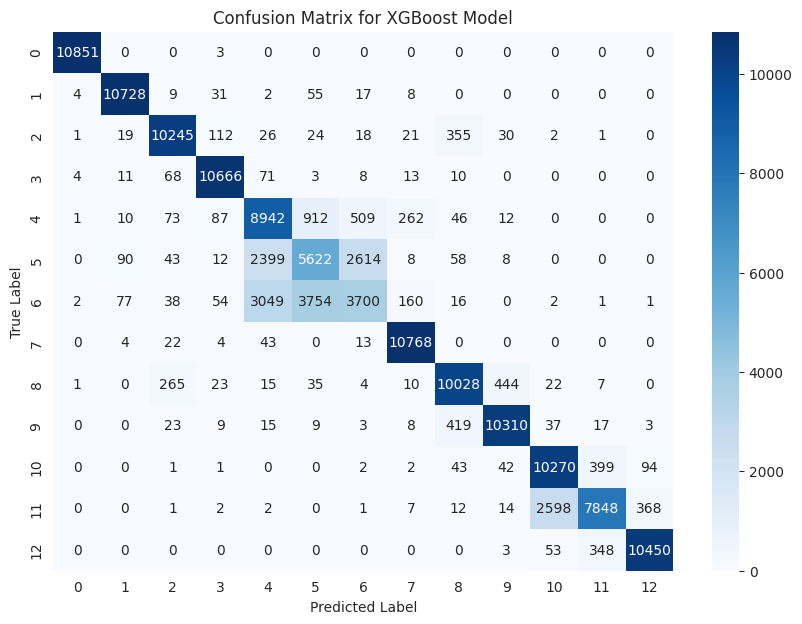

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()


In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    eval_metric=['mlogloss', 'merror'],  # Add 'merror' to track accuracy
    n_estimators=500,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)


[0]	validation_0-mlogloss:2.49061	validation_0-merror:0.25594	validation_1-mlogloss:2.49153	validation_1-merror:0.26712
[1]	validation_0-mlogloss:2.42316	validation_0-merror:0.22907	validation_1-mlogloss:2.42507	validation_1-merror:0.24064
[2]	validation_0-mlogloss:2.36095	validation_0-merror:0.21385	validation_1-mlogloss:2.36374	validation_1-merror:0.22564
[3]	validation_0-mlogloss:2.30286	validation_0-merror:0.20704	validation_1-mlogloss:2.30640	validation_1-merror:0.21844
[4]	validation_0-mlogloss:2.24855	validation_0-merror:0.20382	validation_1-mlogloss:2.25296	validation_1-merror:0.21469
[5]	validation_0-mlogloss:2.19763	validation_0-merror:0.20040	validation_1-mlogloss:2.20285	validation_1-merror:0.21269
[6]	validation_0-mlogloss:2.14989	validation_0-merror:0.19842	validation_1-mlogloss:2.15587	validation_1-merror:0.21117
[7]	validation_0-mlogloss:2.10499	validation_0-merror:0.19567	validation_1-mlogloss:2.11168	validation_1-merror:0.20912
[8]	validation_0-mlogloss:2.06160	valida

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['mlogloss', 'merror'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=13, num_parallel_tree=None, ...)

Test Accuracy: 0.8535

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10854
           1       0.98      0.99      0.98     10854
           2       0.95      0.94      0.95     10854
           3       0.97      0.98      0.98     10854
           4       0.61      0.82      0.70     10854
           5       0.54      0.52      0.53     10854
           6       0.54      0.34      0.42     10854
           7       0.96      0.99      0.97     10854
           8       0.91      0.92      0.92     10854
           9       0.95      0.95      0.95     10853
          10       0.79      0.95      0.86     10854
          11       0.91      0.72      0.81     10853
          12       0.96      0.96      0.96     10854

    accuracy                           0.85    141100
   macro avg       0.85      0.85      0.85    141100
weighted avg       0.85      0.85      0.85    141100



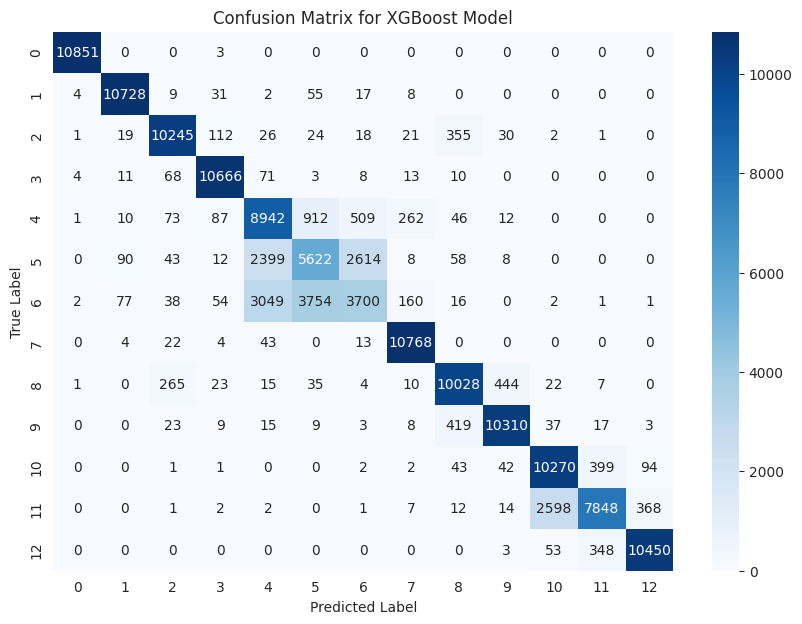

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

Epoch 1/30
2205/2205 [==============================] - 9s 4ms/step - loss: 0.4535 - accuracy: 0.8016 - val_loss: 0.2749 - val_accuracy: 0.8573
Epoch 2/30
2205/2205 [==============================] - 8s 3ms/step - loss: 0.3101 - accuracy: 0.8463 - val_loss: 0.2686 - val_accuracy: 0.8595
Epoch 3/30
2205/2205 [==============================] - 8s 4ms/step - loss: 0.2958 - accuracy: 0.8513 - val_loss: 0.2578 - val_accuracy: 0.8632
Epoch 4/30
2205/2205 [==============================] - 8s 4ms/step - loss: 0.2895 - accuracy: 0.8536 - val_loss: 0.2625 - val_accuracy: 0.8609
Epoch 5/30
2205/2205 [==============================] - 8s 4ms/step - loss: 0.2855 - accuracy: 0.8550 - val_loss: 0.2556 - val_accuracy: 0.8630
Epoch 6/30
2205/2205 [==============================] - 8s 4ms/step - loss: 0.2822 - accuracy: 0.8560 - val_loss: 0.2554 - val_accuracy: 0.8549
Epoch 7/30
2205/2205 [==============================] - 8s 4ms/step - loss: 0.2801 - accuracy: 0.8568 - val_loss: 0.2528 - val_accuracy:

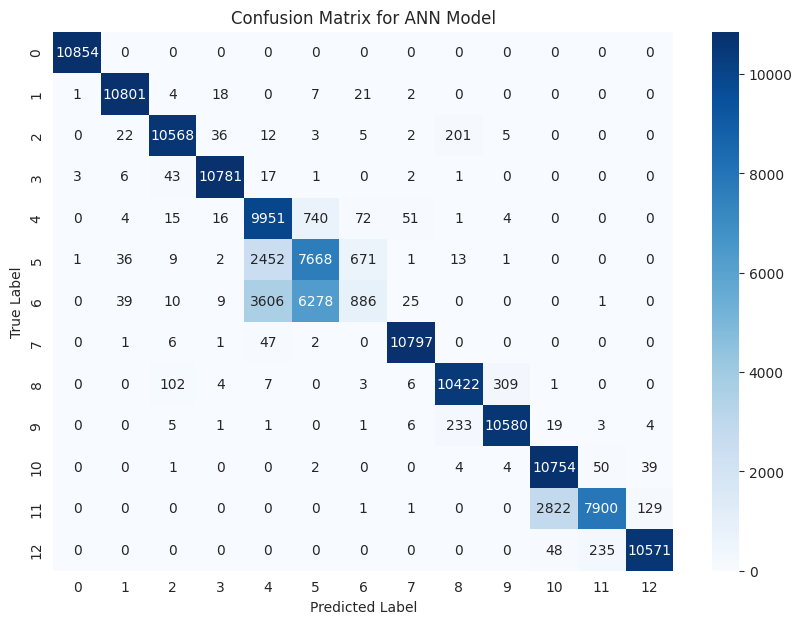

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False) # Change sparse to sparse_output

y_train_onehot = encoder.fit_transform(y_train.values.reshape(-1,1))
y_test_onehot = encoder.transform(y_test.values.reshape(-1,1))

# Define ANN model architecture
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input Layer
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),  # Hidden Layer 1
    Dropout(0.3),
    Dense(32, activation='relu'),  # Hidden Layer 2
    Dense(y_train_onehot.shape[1], activation='softmax')  # Output Layer (Multi-class Classification)
])

# Compile the model
ann_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the ANN model
history = ann_model.fit(X_train, y_train_onehot,
                        epochs=30,  # You can increase epochs for better training
                        batch_size=256,
                        validation_data=(X_test, y_test_onehot),
                        verbose=1)

# Make predictions
y_pred_ann = ann_model.predict(X_test)
y_pred_labels = encoder.inverse_transform(y_pred_ann)

# Calculate accuracy
accuracy_ann = accuracy_score(y_test, y_pred_labels)
print(f"ANN Model Accuracy: {accuracy_ann:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion Matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred_labels), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for ANN Model")
plt.show()


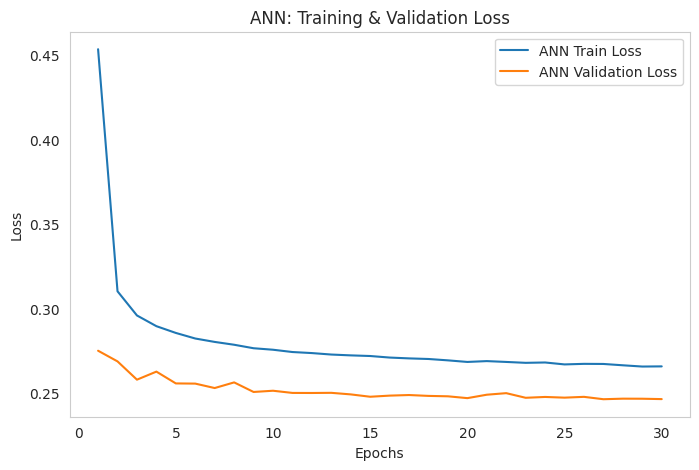

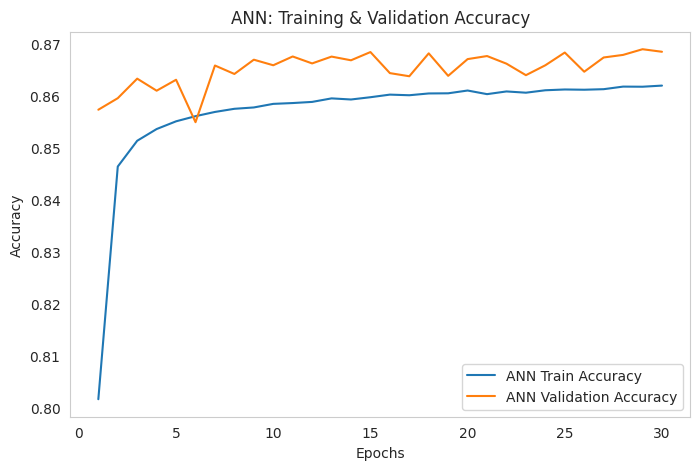

In [ ]:


# Extract ANN training history
ann_train_loss = history.history['loss']
ann_val_loss = history.history['val_loss']
ann_train_acc = history.history['accuracy']
ann_val_acc = history.history['val_accuracy']
epochs_ann = range(1, len(ann_train_loss) + 1)

# --- ANN: Training & Validation Loss ---
plt.figure(figsize=(8, 5))
plt.plot(epochs_ann, ann_train_loss, label='ANN Train Loss')
plt.plot(epochs_ann, ann_val_loss, label='ANN Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN: Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

# --- ANN: Training & Validation Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(epochs_ann, ann_train_acc, label='ANN Train Accuracy')
plt.plot(epochs_ann, ann_val_acc, label='ANN Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ANN: Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(xgb_model.evals_result_)


{'validation_0': OrderedDict([('mlogloss', [2.4906064177004605, 2.4231622458443334, 2.360951940024219, 2.302861137234699, 2.248548009674712, 2.1976290306016795, 2.1498880538207903, 2.104992020229154, 2.061599984650653, 2.0203465705895014, 1.980900937666325, 1.9443824287220381, 1.9089734865408816, 1.8744630837884169, 1.841359285231665, 1.8099730432821477, 1.7796765669033976, 1.7504689640748483, 1.721925043532053, 1.6943264260914792, 1.66774769837789, 1.6419842722220352, 1.617351396409437, 1.5935379499502391, 1.5702781716054794, 1.5476094166927523, 1.5258111579708937, 1.5043715140244103, 1.4834761551751914, 1.4631696840203523, 1.4434155802417004, 1.4243875877707757, 1.4059755798199534, 1.3877238699152086, 1.3699198008224869, 1.352562325042461, 1.3358153863516091, 1.3197299577433796, 1.303644043111076, 1.2879480695302985, 1.2723564413924426, 1.2573583644353532, 1.2426520767297786, 1.2280704258812558, 1.2140848681864238, 1.2002166882075875, 1.1867829678162318, 1.1734409375735053, 1.1606252

In [ ]:
import json

# Save the evaluation results to a JSON file
with open("xgb_evals_result.json", "w") as f:
    json.dump(xgb_model.evals_result_, f)

print("Saved XGBoost evaluation results to xgb_evals_result.json")


Saved XGBoost evaluation results to xgb_evals_result.json


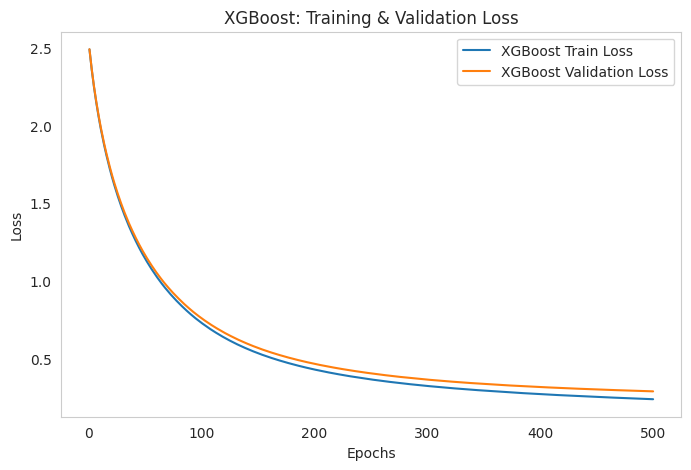

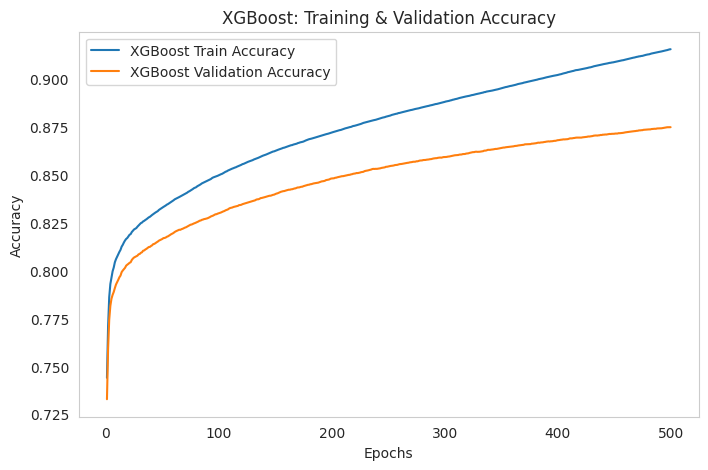

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Extract XGBoost training and validation loss
xgb_train_loss = xgb_model.evals_result_['validation_0']['mlogloss']
xgb_val_loss = xgb_model.evals_result_['validation_1']['mlogloss']
epochs_xgb = range(1, len(xgb_train_loss) + 1)

# --- XGBoost: Training & Validation Loss ---
plt.figure(figsize=(8, 5))
plt.plot(epochs_xgb, xgb_train_loss, label='XGBoost Train Loss')
plt.plot(epochs_xgb, xgb_val_loss, label='XGBoost Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("XGBoost: Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()


import json

# Load the saved XGBoost evaluation results file
with open("xgb_evals_result.json", "r") as f:
    xgb_evals_result_correct = json.load(f)

# Extract XGBoost training and validation error (merror)
xgb_train_error = xgb_evals_result_correct['validation_0']['merror']
xgb_val_error = xgb_evals_result_correct['validation_1']['merror']

# Convert error to accuracy (Accuracy = 1 - Error)
xgb_train_acc = [1 - err for err in xgb_train_error]
xgb_val_acc = [1 - err for err in xgb_val_error]

epochs_xgb = range(1, len(xgb_train_acc) + 1)

# Plot XGBoost Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs_xgb, xgb_train_acc, label='XGBoost Train Accuracy')
plt.plot(epochs_xgb, xgb_val_acc, label='XGBoost Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("XGBoost: Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.show()


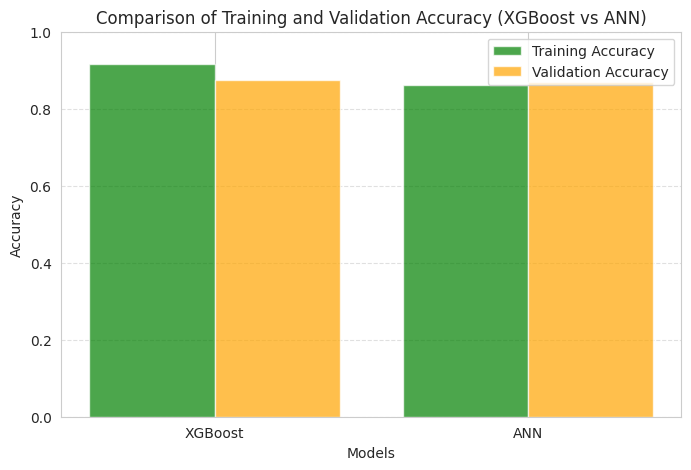

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select last epoch's accuracy for comparison
xgb_final_train_acc = xgb_train_acc[-1]
xgb_final_val_acc = xgb_val_acc[-1]

# Extract ANN final accuracy values
ann_final_train_acc = ann_train_acc[-1]
ann_final_val_acc = ann_val_acc[-1]

# Labels and values
models = ['XGBoost', 'ANN']
train_acc_values = [xgb_final_train_acc, ann_final_train_acc]
val_acc_values = [xgb_final_val_acc, ann_final_val_acc]

# Bar width
bar_width = 0.4
x = np.arange(len(models))

# Create Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, train_acc_values, width=bar_width, label='Training Accuracy', color='green', alpha=0.7)
plt.bar(x + bar_width/2, val_acc_values, width=bar_width, label='Validation Accuracy', color='orange', alpha=0.7)

# Labels and Titles
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Training and Validation Accuracy (XGBoost vs ANN)")
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show plot
plt.show()


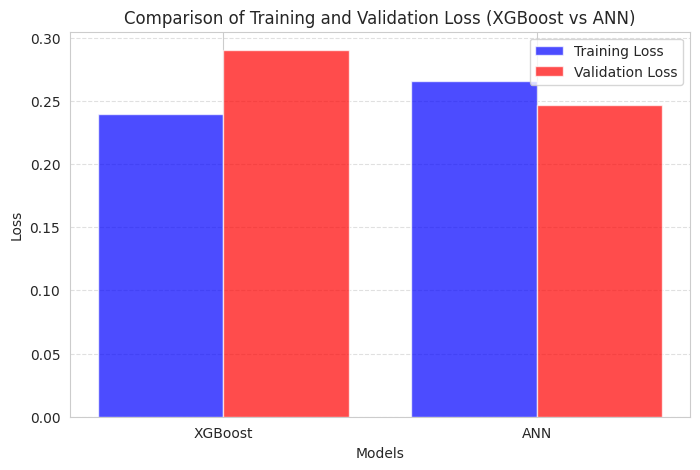

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select last epoch's loss for comparison
xgb_final_train_loss = xgb_train_loss[-1]
xgb_final_val_loss = xgb_val_loss[-1]

# Extract ANN final loss values
ann_final_train_loss = ann_train_loss[-1]
ann_final_val_loss = ann_val_loss[-1]

# Labels and values
models = ['XGBoost', 'ANN']
train_loss_values = [xgb_final_train_loss, ann_final_train_loss]
val_loss_values = [xgb_final_val_loss, ann_final_val_loss]

# Create Bar Chart for Loss
plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, train_loss_values, width=bar_width, label='Training Loss', color='blue', alpha=0.7)
plt.bar(x + bar_width/2, val_loss_values, width=bar_width, label='Validation Loss', color='red', alpha=0.7)

# Labels and Titles
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Comparison of Training and Validation Loss (XGBoost vs ANN)")
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show plot
plt.show()
